<a href="https://colab.research.google.com/github/kostarakonjac1331/Anti_attack_network/blob/main/anti_attack_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTOVI


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.models import  Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Dense,LeakyReLU,BatchNormalization,Dropout,Input,MaxPool2D,Flatten,Activation
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import itertools
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import zipfile
import os
import random
import cv2
from scipy.ndimage.filters import gaussian_filter
import random
from tensorflow.keras.utils import to_categorical

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#KONVOLUCIONI AUTOENCODER

Autoenkoderi sluze za kompresovanje i dekompresovanje podataka. Mozemo ih koristiti za skidanje suma sa slika, detekciju anomalija, kompresiju podataka za velike fajlove koje zelimo da skinemo, koji se posle dekompresuju na nasem uredjaju. Autoenkoderi se sastoje iz dva dela: enkoder (deo koji je zasluzan za kompresovanje podataka) i dekoder(deo koji je zasluzan za dekompresovanje podataka). U nasem slucaju nas enkoder se sastoji iz 2d konvolucionih slojeva i leakyReLu aktivacione funkcije sa padom od 0.001. Kada se prodje jedan konvolucioni sloj smanjuje se velicina slika za 2 puta. Dekoder se sastoji od 2d transponovanih konvolucionih slojeva i LeakyReLu aktivacija koje imaju isti pad kao i u enkoderu. 2d transponovani konvolucioni slojevi sluze za povecavanje dimenzija nase kompresovane slike i vracanje izgleda u prvobitno stanje. Na kraju imamo jedan 2d konvolucioni sloj koji sluzi da vratimo originalni oblik slike.




In [3]:
class AutoEncoder(Model):
  def __init__(self,input_shape):
    super(AutoEncoder,self).__init__()
    #encoder mreza
    self.encoder = keras.Sequential([
      Input(shape=input_shape),
      Conv2D(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001),
      Conv2D(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001)
    ])

    #decoder mreza
    self.decoder = keras.Sequential([
      Conv2DTranspose(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001),
      Conv2DTranspose(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001),
      Conv2D(input_shape[2],kernel_size=3,padding='same'),
      LeakyReLU(0.001)
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




#KONVOLUCIONI KLASIFIKATOR

Nasa neuronska mreza za klasifikaciju se sastoji od 4 ciklusa 2d konvolucionih slojeva sa LeakyRelu aktivacijom ciji je pad 0.2. Posle svakog konvolucionog sloja imamo i dropout od 20%. Posle flatten sloja imamo guste slojeve koji takodje kao aktivacionu funkciju korste LeakyReLu ali imaju i sloj za batch normalizaciju. Batch normalizaciju koristimo za ubrzavanje ucenja nase mreze tako sto cemo normalizovati inpute nasih slojeva. Ovu mrezu smo kreirali pomocu keras subclassing api-a.

In [4]:
class ConvBlock(layers.Layer):
  def __init__(self,out_channels,kernel_size=3):
    super(ConvBlock,self).__init__()
    self.conv = Conv2D(out_channels,kernel_size,padding='same')
    self.leaky = LeakyReLU(0.2)
    self.bn = BatchNormalization()
    self.pool = MaxPool2D()
    self.drop = Dropout(0.2)
  def call(self, x):
    x = self.leaky(self.conv(x))
    x = self.bn(x)
    x = self.pool(x)
    x = self.drop(x)
    return x

In [5]:
class FCBlock(layers.Layer):
  def __init__(self,out_channels,dor = 0.2):
    super(FCBlock,self).__init__()
    self.dense = Dense(out_channels)
    self.leaky = LeakyReLU(0.2)
    self.drop = Dropout(dor)
    self.bn = BatchNormalization()
  def call(self,x):
    x = self.leaky(self.dense(x))
    x = self.bn(x)
    x = self.drop(x)
    return x


In [6]:
class CNNClassifier(Model):
  def __init__(self,number_of_classes):
    super(CNNClassifier,self).__init__()
    self.conv1 = ConvBlock(16)
    self.conv2 = ConvBlock(32)
    self.conv3 = ConvBlock(64)
    self.conv4 = ConvBlock(128)
    self.flat = Flatten()
    self.fc1 = FCBlock(512, dor = 0.3)
    self.fc2 = FCBlock(128, dor = 0.3)
    self.fc3 = FCBlock(64, dor = 0.2)
    self.fc4 = Dense(number_of_classes)
    self.softmax = keras.layers.Activation('softmax')
  def call(self,x,training = False):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.flat(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    x = self.softmax(x)
    return x

In [49]:
class Classifier:
  def __init__(self,x_train,x_test,y_train,y_test,class_names):
    self.cnn = CNNClassifier(len(class_names))
    self.x_train = x_train
    self.x_test = x_test
    self.y_train = y_train
    self.y_test = y_test
    self.class_names = class_names
    self.predictions = None
    self.history = None

  def train_classifier(self):
    self.cnn.compile(
      loss='categorical_crossentropy',
      optimizer=keras.optimizers.Adam(lr=3e-4),
      metrics=["accuracy"],
    )
    self.history = self.cnn.fit(self.x_train, self.y_train, batch_size=256, epochs=100, verbose=2,validation_data=(self.x_test,self.y_test))
    self.predictions = self.cnn.predict(x=self.x_test, batch_size=256, verbose=0)
  
  def predict(self,picture):
    picture = tf.expand_dims(input=picture,axis = 0)
    prediction = 0
    with tf.GradientTape() as tape:
      prediction = self.cnn(picture)

    return prediction


  def plot_accuracy(self):
    plt.plot(self.history.history['accuracy'], label='accuracy')
    plt.plot(self.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
  
  def plot_loss(self):
    plt.plot(self.history.history['loss'], label='loss')
    plt.plot(self.history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend(loc='lower right')


  def plot_confusion_matrix(self,target_names,title='Matrica konfuzije',cmap=None,normalize=True):
    tacne_labele = []
    pred_labele = []
    for i in range(len(self.y_test)):
        tacne_labele.append(np.argmax(self.y_test[i]))
        pred_labele.append(np.argmax(self.predictions[i]))
    test = np.array(tacne_labele)
    pred = np.array(pred_labele)
    
    
    
    cm = confusion_matrix(y_true=test, y_pred=pred)
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
      cmap = plt.get_cmap('magma')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)

    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thtest_labelsresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="red")
      else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="red")


    plt.tight_layout()
    plt.ylabel('Tacne klase')
    plt.xlabel('Prediktovane klase\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


  def procenat_tacnosti_pre_ciscenja(self,x_test_attacked):
    broj_tacnih_predikcija = 0
    
    predikcije = self.cnn.predict(x_test_attacked)
    for i in range(len(predikcije)):
      if(np.argmax(predikcije[i]) == np.argmax(y_test[i])):
        broj_tacnih_predikcija+=1
        
    procenat_tacnosti = broj_tacnih_predikcija/len(self.y_test)

    labels = 'Tacne predikcije', 'Netacne predikcije'
    sizes = [procenat_tacnosti*100. ,(1-procenat_tacnosti)*100]
    explode = (0, 0.1)  

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 

    plt.show()

  def procenat_tacnosti_posle_ciscenja(self,denoiser,x_test_attacked):
    broj_tacnih_predikcija = 0

    ociscen_skup = denoiser.autoencoder(x_test_attacked)
    predikcije = self.cnn.predict(ociscen_skup)

    for i in range(len(predikcije)):
      if(np.argmax(predikcije[i]) == np.argmax(y_test[i])):
        broj_tacnih_predikcija+=1
        
    procenat_tacnosti = broj_tacnih_predikcija/len(self.y_test)

    labels = 'Tacne predikcije', 'Netacne predikcije'
    sizes = [procenat_tacnosti*100. ,(1-procenat_tacnosti)*100]
    explode = (0, 0.1)  

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 

    plt.show()


In [9]:
class Denoiser:
  def __init__(self,x_train,x_train_attacked,x_test_attacked,input_shape):
    self.autoencoder = AutoEncoder(input_shape=input_shape)
    self.x_train = x_train
    self.x_train_attacked = x_train_attacked
    self.x_test_attacked = x_test_attacked

  def train_autoencoder(self):
    self.autoencoder.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())

    self.autoencoder.fit(self.x_train_attacked, self.x_train,
                epochs=15,
                shuffle=True)
    print(self.autoencoder.encoder.summary())
    print(self.autoencoder.decoder.summary())
    self.__rezultat_treniranja_ae()

  def encoding_decoding(self,picture):
    picture = tf.expand_dims(input = picture, axis = 0)
    enc = self.autoencoder.encoder(picture)
    dec = self.autoencoder.decoder(enc)

    return dec


  def __rezultat_treniranja_ae(self):
    print("rezultat treniranja: \n")
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
      cleaned = self.encoding_decoding(self.x_test_attacked[i])
      ax = plt.subplot(2, n, i + 1)
      plt.title("original")
      plt.imshow(tf.squeeze(self.x_test_attacked[i]))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      bx = plt.subplot(2, n, i + n + 1)
      plt.title("rekonstruisana")
      plt.imshow(tf.squeeze(cleaned))
      plt.gray()
      bx.get_xaxis().set_visible(False)
      bx.get_yaxis().set_visible(False)
    plt.show()
  

In [10]:
def create_attack(x_train,x_test,attack_type,input_shape, classifier = None, y_test = None, eps = 0.1):
  # random noise attack
  if(attack_type == 1):

    x_train_attacked = x_train + eps * tf.random.normal(shape=x_train.shape) 
    x_test_attacked = x_test + eps * tf.random.normal(shape=x_test.shape) 

    x_train_attacked = tf.clip_by_value(x_train_attacked, clip_value_min=0., clip_value_max=1.)
    x_test_attacked = tf.clip_by_value(x_test_attacked, clip_value_min=0., clip_value_max=1.)

    denoiser = Denoiser(x_train,x_train_attacked,x_test_attacked,input_shape)
    return denoiser,x_train_attacked,x_test_attacked
  #FGSM attack
  elif(attack_type == 2):

    slika = tf.convert_to_tensor(x_test[0])

    probs = classifier.cnn(tf.expand_dims(input=slika,axis=0))

    label = tf.one_hot(np.argmax(y_test[0]), probs.shape[-1])
    label = tf.reshape(label, (1, probs.shape[-1]))

    loss_object = keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
      tape.watch(slika)
      predikcija = classifier.cnn(tf.expand_dims(input=slika,axis=0))
      loss = loss_object(label,predikcija)
    
    gradient = tape.gradient(loss,slika)
    
    signed_grad = tf.sign(gradient)
    
    x_train_attacked = x_train + eps * signed_grad
    x_test_attacked = x_test + eps * signed_grad

    x_train_attacked = tf.clip_by_value(x_train_attacked, clip_value_min=0., clip_value_max=1.)
    x_test_attacked = tf.clip_by_value(x_test_attacked, clip_value_min=0., clip_value_max=1.)

    denoiser = Denoiser(x_train,x_train_attacked,x_test_attacked,input_shape)

    return denoiser,x_train_attacked,x_test_attacked
  # Gauss-blur
  elif(attack_type == 3):
    x_train_attacked = []
    x_test_attacked = []
    
    for i in x_train:
      x_train_attacked.append(gaussian_filter(i,sigma=0.9))
    
    for i in x_test:
      x_test_attacked.append(gaussian_filter(i,sigma=0.9))
    
    x_train_attacked = np.array(x_train_attacked)
    x_test_attacked = np.array(x_test_attacked)
    denoiser = Denoiser(x_train,x_train_attacked,x_test_attacked,input_shape)
    return (denoiser,x_train_attacked,x_test_attacked)
  
  
  # Random missing pixels
  elif(attack_type == 4):
    
    amount = int(input_shape[0]*input_shape[1]*0.05)

    x_train_attacked = []
    x_test_attacked = []

    for i in x_train:
      pic = np.array(i)
      cor = [(random.randrange(0, input_shape[0]), random.randrange(0, input_shape[1])) for i in range(amount)]
      for j in range(input_shape[2]):
        for z in cor:
          pic[z[0]][z[1]][j] = 0
      x_train_attacked.append(pic)


    for i in x_test:
      pic = np.array(i)
      cor = [(random.randrange(0, input_shape[0]), random.randrange(0, input_shape[1])) for i in range(amount)]
      for j in range(input_shape[2]):
        for z in cor:
          pic[z[0]][z[1]][j] = 0
      x_test_attacked.append(pic)

    x_train_attacked = np.array(x_train_attacked)
    x_test_attacked = np.array(x_test_attacked)

    denoiser = Denoiser(x_train,x_train_attacked,x_test_attacked,input_shape)

    return (denoiser,x_train_attacked,x_test_attacked)

    



#Ucitavanje prvog dataseta: CIFAR10

Cifar10 se sastoji od 60000 slika koje su dimenzija 32X32 sa 3 color channela.

In [11]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()



x_train = x_train.astype("float32") /255.0
x_test = x_test.astype("float32") / 255.0


y_train = to_categorical(y=y_train,num_classes=10)
y_test = to_categorical(y=y_test,num_classes=10)

#Klase CIFAR10 dataseta

In [22]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [50]:
clas = Classifier(x_train,x_test,y_train,y_test,class_names)

#Ucitavanje drugog dataseta: FASHON MNIST

Fashon mnist dataset se sastoji od 60000 slika koje su dimenzija 28X28 sa jednim color channelom.

In [51]:
clas.train_classifier()

Epoch 1/100
196/196 - 4s - loss: 2.1347 - accuracy: 0.2699 - val_loss: 3.1333 - val_accuracy: 0.1173
Epoch 2/100
196/196 - 2s - loss: 1.6909 - accuracy: 0.3843 - val_loss: 2.6043 - val_accuracy: 0.1974
Epoch 3/100
196/196 - 2s - loss: 1.5555 - accuracy: 0.4308 - val_loss: 1.8231 - val_accuracy: 0.3880
Epoch 4/100
196/196 - 2s - loss: 1.4663 - accuracy: 0.4624 - val_loss: 1.5161 - val_accuracy: 0.4764
Epoch 5/100
196/196 - 2s - loss: 1.3905 - accuracy: 0.4941 - val_loss: 1.3348 - val_accuracy: 0.5349
Epoch 6/100
196/196 - 2s - loss: 1.3222 - accuracy: 0.5187 - val_loss: 1.3358 - val_accuracy: 0.5343
Epoch 7/100
196/196 - 2s - loss: 1.2761 - accuracy: 0.5388 - val_loss: 1.2413 - val_accuracy: 0.5661
Epoch 8/100
196/196 - 2s - loss: 1.2252 - accuracy: 0.5619 - val_loss: 1.1138 - val_accuracy: 0.6045
Epoch 9/100
196/196 - 2s - loss: 1.1758 - accuracy: 0.5803 - val_loss: 1.1597 - val_accuracy: 0.5973
Epoch 10/100
196/196 - 2s - loss: 1.1408 - accuracy: 0.5889 - val_loss: 1.0718 - val_accura

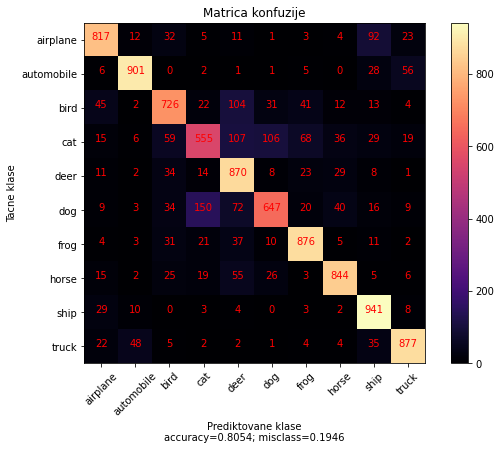

In [52]:
clas.plot_confusion_matrix(class_names,normalize=False)

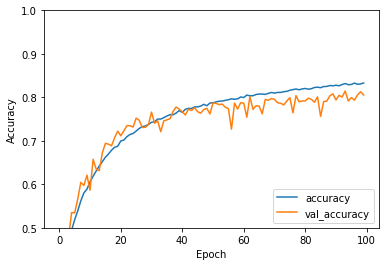

In [53]:
clas.plot_accuracy()

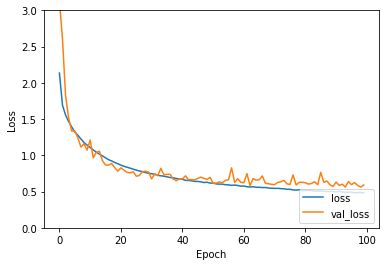

In [54]:
clas.plot_loss()

# RANDOM NOISE ATTACK

In [55]:
val = create_attack(x_train,x_test,1,(32,32,3),eps=0.2)

In [56]:
rnaDenoiser = val[0]

Epoch 1/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0160
Epoch 2/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0042
Epoch 3/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0040
Epoch 4/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0039
Epoch 5/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0038
Epoch 6/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0038
Epoch 7/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0037
Epoch 8/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0037
Epoch 9/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0037
Epoch 10/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0037
Epoch 11/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0036
Epoch 12/15
1563/1563 [==============================] - 10s 6ms/step - los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 8, 8, 64)          0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 64)        36928     
_______________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


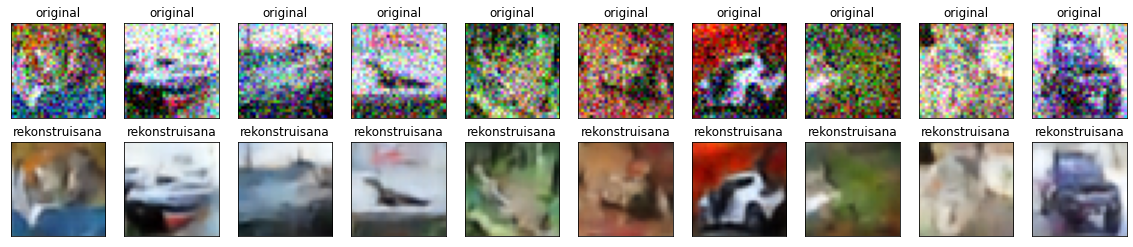

In [57]:
rnaDenoiser.train_autoencoder()

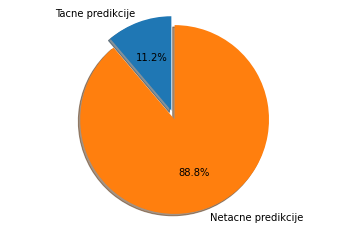

In [58]:
clas.procenat_tacnosti_pre_ciscenja(val[2])

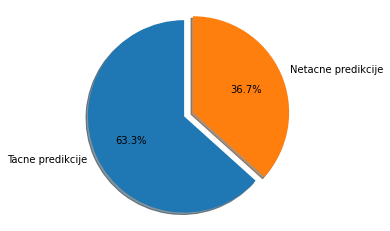

In [59]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=rnaDenoiser,x_test_attacked=val[2])

#FGSM ATTACK

In [ ]:
val = create_attack(x_train,x_test,2,(32,32,3),classifier=clas,y_test=y_test,eps=0.2)

In [ ]:
fgsmDenoiser = val[0]

Epoch 1/15
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0135
Epoch 2/15
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0014
Epoch 3/15
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0010
Epoch 4/15
1563/1563 [==============================] - 18s 12ms/step - loss: 8.5251e-04
Epoch 5/15
1563/1563 [==============================] - 18s 12ms/step - loss: 7.5186e-04
Epoch 6/15
1563/1563 [==============================] - 18s 12ms/step - loss: 6.8439e-04
Epoch 7/15
1563/1563 [==============================] - 18s 12ms/step - loss: 6.1825e-04
Epoch 8/15
1563/1563 [==============================] - 18s 12ms/step - loss: 6.0135e-04
Epoch 9/15
1563/1563 [==============================] - 18s 12ms/step - loss: 5.5318e-04
Epoch 10/15
1563/1563 [==============================] - 18s 12ms/step - loss: 5.0786e-04
Epoch 11/15
1563/1563 [==============================] - 18s 12ms/step - loss: 4.9576e-04
Epoch 12/15
1563/1563 [========

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


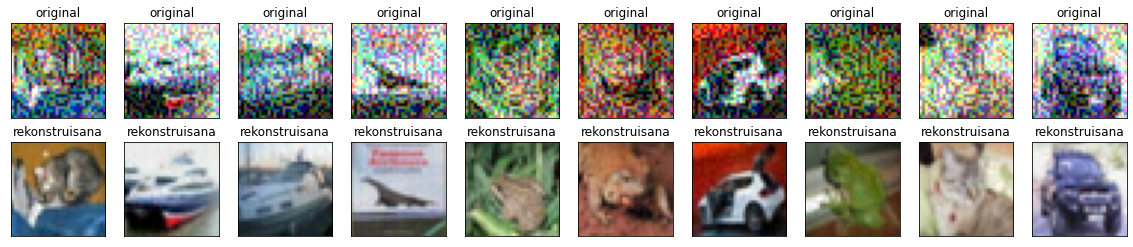

In [ ]:
fgsmDenoiser.train_autoencoder()

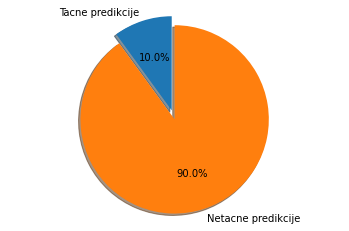

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(val[2])

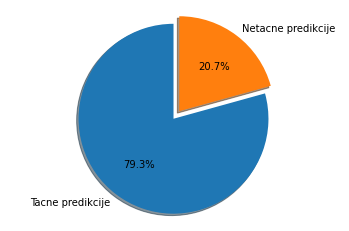

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=fgsmDenoiser,x_test_attacked = val[2])

#GAUSSIAN BLUR NAPAD

In [ ]:
val = create_attack(x_train,x_test,3,(32,32,3))

In [ ]:
gaussDenoiser = val[0]

Epoch 1/15
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0136
Epoch 2/15
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0013
Epoch 3/15
1563/1563 [==============================] - 18s 12ms/step - loss: 9.4551e-04
Epoch 4/15
1563/1563 [==============================] - 18s 12ms/step - loss: 7.8460e-04
Epoch 5/15
1563/1563 [==============================] - 18s 12ms/step - loss: 7.0261e-04
Epoch 6/15
1563/1563 [==============================] - 18s 12ms/step - loss: 6.4245e-04
Epoch 7/15
1563/1563 [==============================] - 18s 12ms/step - loss: 5.4962e-04
Epoch 8/15
1563/1563 [==============================] - 18s 12ms/step - loss: 5.0306e-04
Epoch 9/15
1563/1563 [==============================] - 18s 12ms/step - loss: 4.6653e-04
Epoch 10/15
1563/1563 [==============================] - 18s 12ms/step - loss: 4.6704e-04
Epoch 11/15
1563/1563 [==============================] - 18s 12ms/step - loss: 3.6109e-04
Epoch 12/15
1563/1563 [====

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


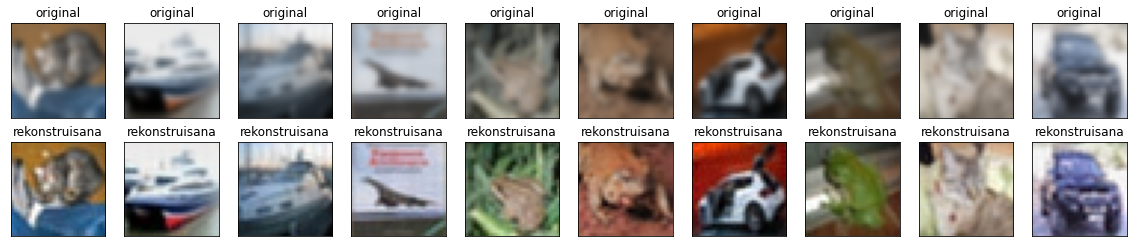

In [ ]:
gaussDenoiser.train_autoencoder()

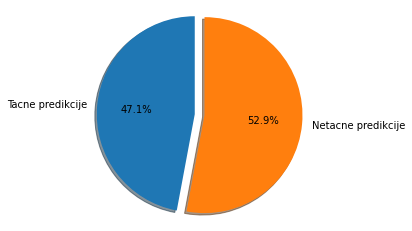

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(val[2])

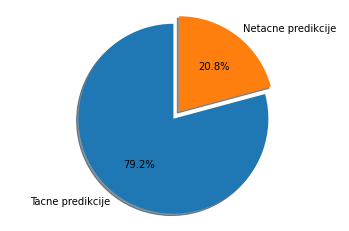

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=gaussDenoiser,x_test_attacked= val[2])

#MISSING PIXEL NAPAD

In [ ]:
val = create_attack(x_train,x_test,4,(32,32,3))

In [ ]:
misPDenoiser = val[0]

Epoch 1/15
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0142
Epoch 2/15
1563/1563 [==============================] - 18s 12ms/step - loss: 8.0378e-04
Epoch 3/15
1563/1563 [==============================] - 18s 12ms/step - loss: 5.9422e-04
Epoch 4/15
1563/1563 [==============================] - 18s 12ms/step - loss: 4.6204e-04
Epoch 5/15
1563/1563 [==============================] - 18s 12ms/step - loss: 4.4566e-04
Epoch 6/15
1563/1563 [==============================] - 18s 12ms/step - loss: 3.7116e-04
Epoch 7/15
1563/1563 [==============================] - 18s 12ms/step - loss: 3.3350e-04
Epoch 8/15
1563/1563 [==============================] - 18s 12ms/step - loss: 3.0886e-04
Epoch 9/15
1563/1563 [==============================] - 18s 12ms/step - loss: 3.1875e-04
Epoch 10/15
1563/1563 [==============================] - 18s 12ms/step - loss: 2.7837e-04
Epoch 11/15
1563/1563 [==============================] - 18s 12ms/step - loss: 3.0537e-04
Epoch 12/15
1563/1563 [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


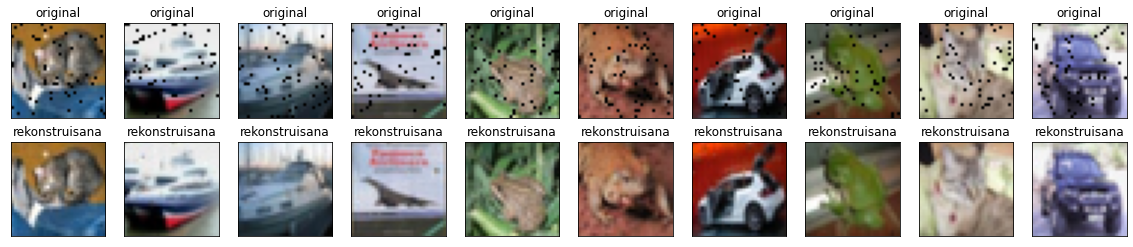

In [ ]:
misPDenoiser.train_autoencoder()

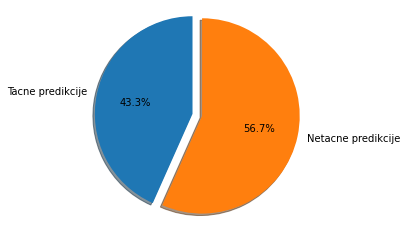

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(val[2])

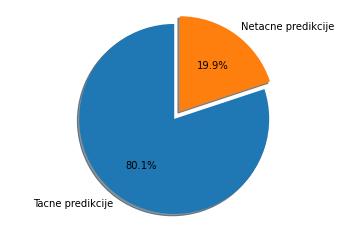

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=misPDenoiser,x_test_attacked= val[2])

#FMNIST SKUP

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") /255.0
x_test = x_test.astype("float32") / 255.0


x_train = tf.expand_dims(input = x_train,axis = 3)
x_test = tf.expand_dims(input = x_test,axis = 3)


y_train = to_categorical(y=y_train,num_classes=10)
y_test = to_categorical(y=y_test,num_classes=10)

#Klase fashon mnist dataseta

In [ ]:
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]


In [ ]:
clas = Classifier(x_train,x_test,y_train,y_test,class_names)

In [ ]:
clas.train_classifier()

Epoch 1/100
235/235 - 3s - loss: 1.1072 - accuracy: 0.6117 - val_loss: 2.4327 - val_accuracy: 0.1633
Epoch 2/100
235/235 - 2s - loss: 0.6674 - accuracy: 0.7536 - val_loss: 1.0643 - val_accuracy: 0.6085
Epoch 3/100
235/235 - 2s - loss: 0.5657 - accuracy: 0.7915 - val_loss: 0.4618 - val_accuracy: 0.8324
Epoch 4/100
235/235 - 2s - loss: 0.5082 - accuracy: 0.8155 - val_loss: 0.4063 - val_accuracy: 0.8544
Epoch 5/100
235/235 - 2s - loss: 0.4664 - accuracy: 0.8315 - val_loss: 0.3925 - val_accuracy: 0.8617
Epoch 6/100
235/235 - 2s - loss: 0.4344 - accuracy: 0.8432 - val_loss: 0.3535 - val_accuracy: 0.8719
Epoch 7/100
235/235 - 2s - loss: 0.4121 - accuracy: 0.8522 - val_loss: 0.3485 - val_accuracy: 0.8746
Epoch 8/100
235/235 - 2s - loss: 0.3902 - accuracy: 0.8598 - val_loss: 0.3290 - val_accuracy: 0.8819
Epoch 9/100
235/235 - 2s - loss: 0.3764 - accuracy: 0.8644 - val_loss: 0.3221 - val_accuracy: 0.8836
Epoch 10/100
235/235 - 2s - loss: 0.3636 - accuracy: 0.8676 - val_loss: 0.3113 - val_accura

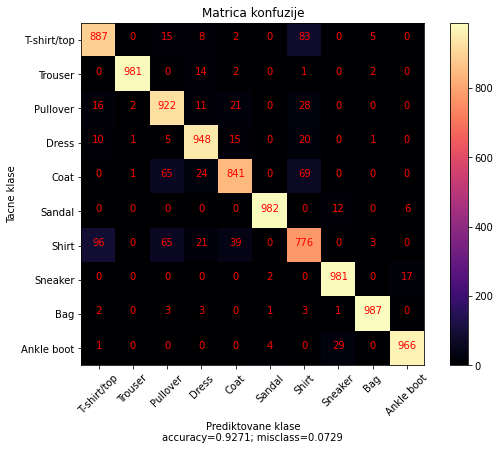

In [ ]:
clas.plot_confusion_matrix(class_names,normalize=False)

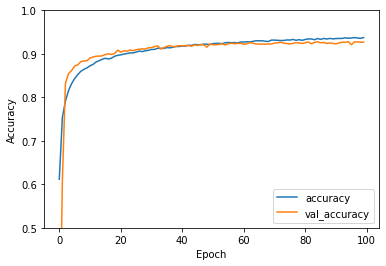

In [ ]:
clas.plot_accuracy()

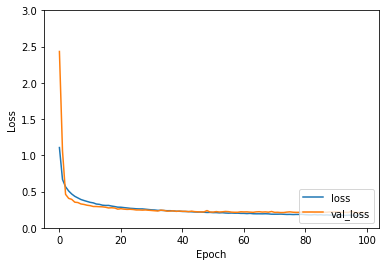

In [ ]:
clas.plot_loss()

#RANDOM NOISE ATTACK

In [ ]:
val = create_attack(x_train,x_test,1,(28,28,1),eps=0.2)

In [ ]:
rnaDenoiser = val[0]

Epoch 1/15
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0152
Epoch 2/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0054
Epoch 3/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0051
Epoch 4/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0049
Epoch 5/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0048
Epoch 6/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0048
Epoch 7/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0047
Epoch 8/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0047
Epoch 9/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0047
Epoch 10/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0046
Epoch 11/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0046
Epoch 12/15
1875/1875 [==============================] - 15s 8ms/step - lo

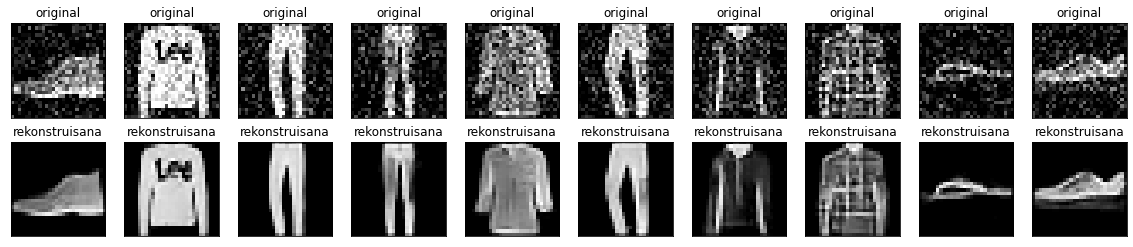

In [ ]:
rnaDenoiser.train_autoencoder()

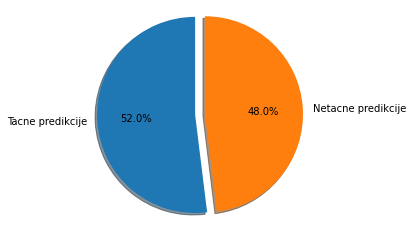

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(x_test_attacked=val[2])

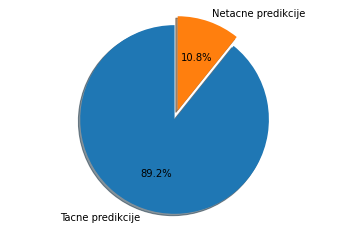

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=rnaDenoiser,x_test_attacked=val[2])

#FGSM ATTACK

In [ ]:
val = create_attack(x_train,x_test,2,(28,28,1),classifier=clas,y_test=y_test,eps=0.2)

In [ ]:
fgsmDenoiser = val[0]

Epoch 1/15
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0140
Epoch 2/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0015
Epoch 3/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0011
Epoch 4/15
1875/1875 [==============================] - 15s 8ms/step - loss: 9.2284e-04
Epoch 5/15
1875/1875 [==============================] - 15s 8ms/step - loss: 7.7706e-04
Epoch 6/15
1875/1875 [==============================] - 15s 8ms/step - loss: 7.0973e-04
Epoch 7/15
1875/1875 [==============================] - 15s 8ms/step - loss: 6.6440e-04
Epoch 8/15
1875/1875 [==============================] - 15s 8ms/step - loss: 6.2141e-04
Epoch 9/15
1875/1875 [==============================] - 15s 8ms/step - loss: 5.9749e-04
Epoch 10/15
1875/1875 [==============================] - 15s 8ms/step - loss: 5.7703e-04
Epoch 11/15
1875/1875 [==============================] - 15s 8ms/step - loss: 5.5836e-04
Epoch 12/15
1875/1875 [===================

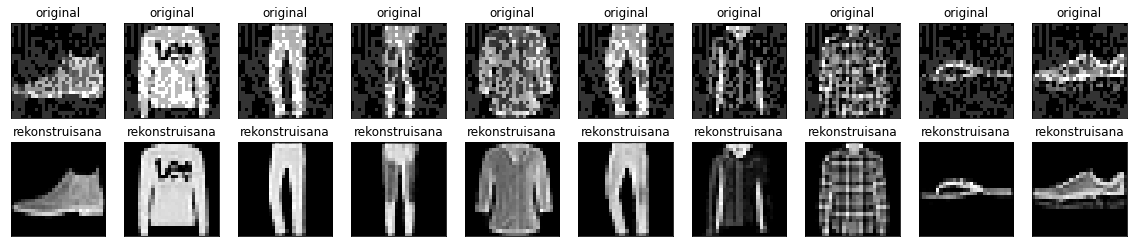

In [ ]:
fgsmDenoiser.train_autoencoder()

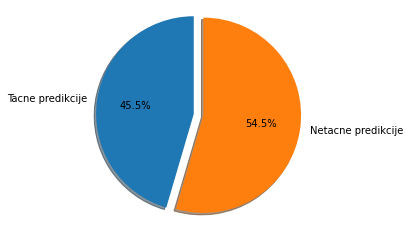

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(x_test_attacked=val[2])

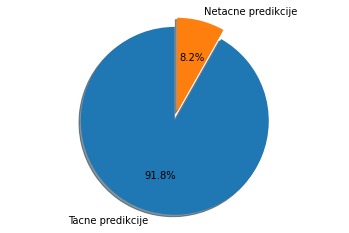

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=fgsmDenoiser,x_test_attacked=val[2])

#GAUSSIAN BLUR NAPAD

In [ ]:
val = create_attack(x_train,x_test,3,(28,28,1))

In [ ]:
gaussDenoiser = val[0]

Epoch 1/15
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0125
Epoch 2/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0016
Epoch 3/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0015
Epoch 4/15
1875/1875 [==============================] - 15s 8ms/step - loss: 9.3796e-04
Epoch 5/15
1875/1875 [==============================] - 15s 8ms/step - loss: 7.2330e-04
Epoch 6/15
1875/1875 [==============================] - 15s 8ms/step - loss: 6.9245e-04
Epoch 7/15
1875/1875 [==============================] - 15s 8ms/step - loss: 6.0702e-04
Epoch 8/15
1875/1875 [==============================] - 15s 8ms/step - loss: 5.0536e-04
Epoch 9/15
1875/1875 [==============================] - 15s 8ms/step - loss: 4.3318e-04
Epoch 10/15
1875/1875 [==============================] - 15s 8ms/step - loss: 3.9327e-04
Epoch 11/15
1875/1875 [==============================] - 15s 8ms/step - loss: 5.0108e-04
Epoch 12/15
1875/1875 [===================

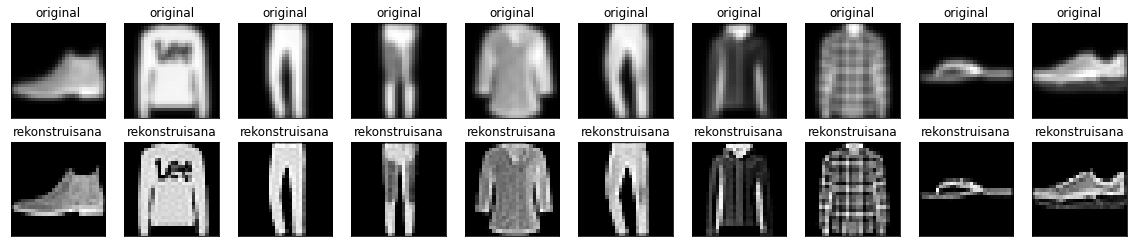

In [ ]:
gaussDenoiser.train_autoencoder()

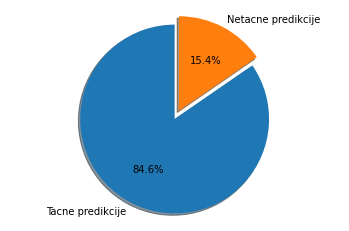

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(val[2])

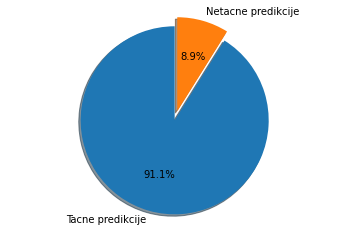

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=gaussDenoiser,x_test_attacked= val[2])

#MISSING PIXEL NAPAD

In [ ]:
val = create_attack(x_train,x_test,4,(28,28,1))

In [ ]:
misPDenoiser = val[0]

Epoch 1/15
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0121
Epoch 2/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0015
Epoch 3/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0011
Epoch 4/15
1875/1875 [==============================] - 15s 8ms/step - loss: 9.3995e-04
Epoch 5/15
1875/1875 [==============================] - 15s 8ms/step - loss: 8.4322e-04
Epoch 6/15
1875/1875 [==============================] - 15s 8ms/step - loss: 7.8114e-04
Epoch 7/15
1875/1875 [==============================] - 15s 8ms/step - loss: 7.1697e-04
Epoch 8/15
1875/1875 [==============================] - 15s 8ms/step - loss: 6.9293e-04
Epoch 9/15
1875/1875 [==============================] - 15s 8ms/step - loss: 6.4452e-04
Epoch 10/15
1875/1875 [==============================] - 15s 8ms/step - loss: 6.1931e-04
Epoch 11/15
1875/1875 [==============================] - 15s 8ms/step - loss: 6.0091e-04
Epoch 12/15
1875/1875 [===================

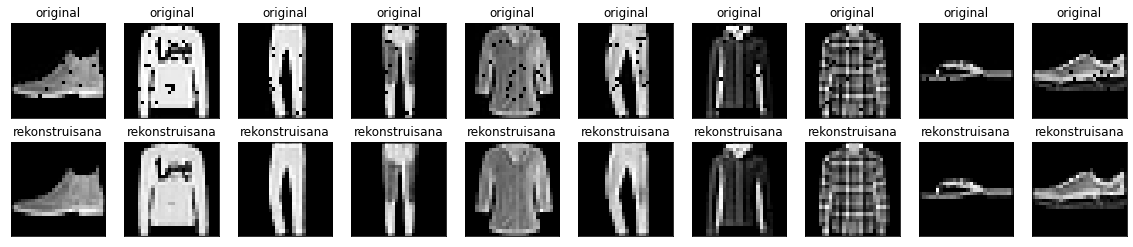

In [ ]:
misPDenoiser.train_autoencoder()

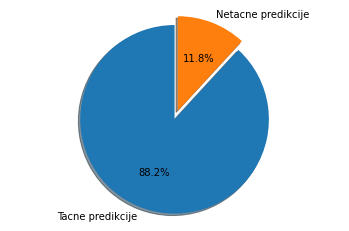

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(val[2])

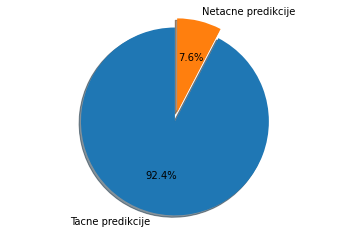

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=misPDenoiser,x_test_attacked= val[2])

#CATS VS DOGS

In [ ]:
train_ds = tfds.load('cats_vs_dogs', split='train')

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete6P5K26/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
def preprocess(features):
  image = tf.image.resize(features['image'], [64,64])
  image = tf.divide(image, 255)
  label = features['label']
  return image, tf.cast(label, tf.float32)

In [ ]:
train_x = train_ds.as_numpy_iterator()
x_train = []
y_train = []

x_test = []
y_test = []

split = int(len(train_ds)*0.8)
brojac = 0
for i in train_x:
  if (brojac>split):
    a = preprocess(i)
    x_test.append(a[0])
    y_test.append(a[1])
  else:
    a = preprocess(i)
    x_train.append(a[0])
    y_train.append(a[1])
    brojac+=1




In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [ ]:
y_test = np.array(y_test)
y_train = np.array(y_train)

y_train = to_categorical(y=y_train,num_classes=2)
y_test = to_categorical(y=y_test,num_classes=2)

In [ ]:
class_names = ["DOG","CAT"]

In [ ]:
clas = Classifier(x_train,x_test,y_train,y_test,class_names)

In [ ]:
clas.train_classifier()

Epoch 1/100
146/146 - 7s - loss: 0.8795 - accuracy: 0.5253 - val_loss: 0.6833 - val_accuracy: 0.6051
Epoch 2/100
146/146 - 4s - loss: 0.7649 - accuracy: 0.5586 - val_loss: 0.6676 - val_accuracy: 0.5724
Epoch 3/100
146/146 - 4s - loss: 0.6853 - accuracy: 0.6183 - val_loss: 0.6543 - val_accuracy: 0.5798
Epoch 4/100
146/146 - 4s - loss: 0.6337 - accuracy: 0.6587 - val_loss: 0.5593 - val_accuracy: 0.7055
Epoch 5/100
146/146 - 4s - loss: 0.5863 - accuracy: 0.6937 - val_loss: 0.5271 - val_accuracy: 0.7395
Epoch 6/100
146/146 - 4s - loss: 0.5579 - accuracy: 0.7191 - val_loss: 0.4986 - val_accuracy: 0.7601
Epoch 7/100
146/146 - 4s - loss: 0.5273 - accuracy: 0.7372 - val_loss: 0.6179 - val_accuracy: 0.7068
Epoch 8/100
146/146 - 4s - loss: 0.5069 - accuracy: 0.7542 - val_loss: 0.7130 - val_accuracy: 0.6586
Epoch 9/100
146/146 - 4s - loss: 0.4876 - accuracy: 0.7659 - val_loss: 0.6219 - val_accuracy: 0.7225
Epoch 10/100
146/146 - 4s - loss: 0.4668 - accuracy: 0.7782 - val_loss: 0.4388 - val_accura

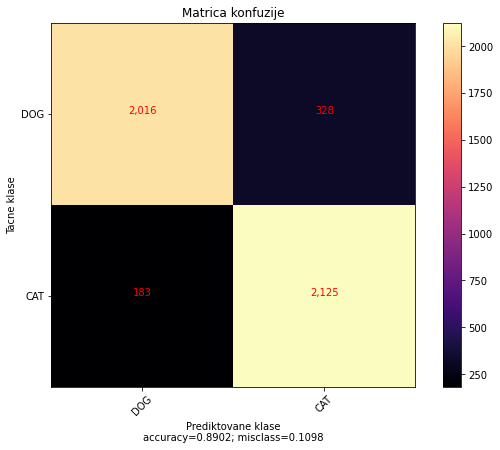

In [ ]:
clas.plot_confusion_matrix(class_names,normalize=False)

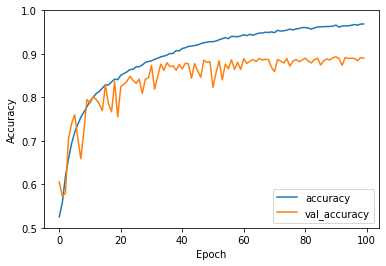

In [ ]:
clas.plot_accuracy()

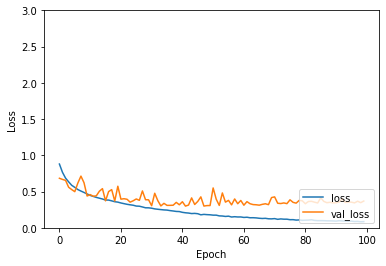

In [ ]:
clas.plot_loss()

#RANDOM NOISE ATTACK

In [ ]:
val = create_attack(x_train,x_test,1,(64,64,3),eps=0.2)

In [ ]:
rnaDenoiser = val[0]

Epoch 1/15
582/582 [==============================] - 20s 33ms/step - loss: 0.0283
Epoch 2/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0056
Epoch 3/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0050
Epoch 4/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0047
Epoch 5/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0045
Epoch 6/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0045
Epoch 7/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0044
Epoch 8/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0044
Epoch 9/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0043
Epoch 10/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0043
Epoch 11/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0042
Epoch 12/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0042
E

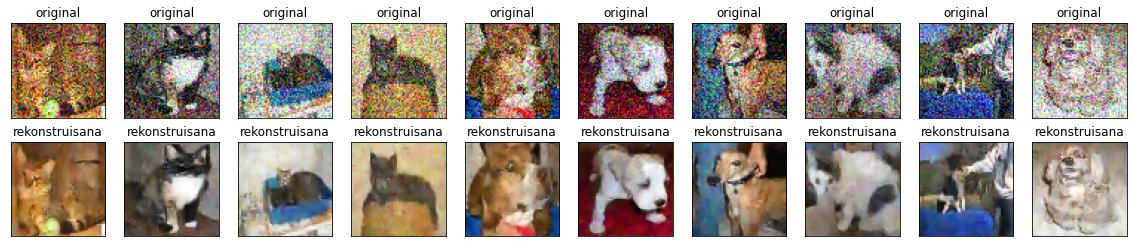

In [ ]:
rnaDenoiser.train_autoencoder()

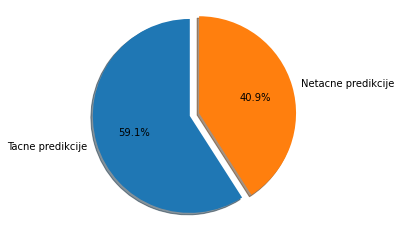

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(x_test_attacked=val[2])

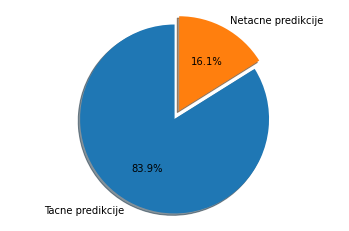

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=rnaDenoiser,x_test_attacked=val[2])

#FGSM ATTACK

In [ ]:
val = create_attack(x_train,x_test,2,(64,64,3),classifier=clas,y_test=y_test,eps=0.2)

In [ ]:
fgsmDenoiser = val[0]

Epoch 1/15
582/582 [==============================] - 20s 33ms/step - loss: 0.0251
Epoch 2/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0043
Epoch 3/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0030
Epoch 4/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0024
Epoch 5/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0021
Epoch 6/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0018
Epoch 7/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0016
Epoch 8/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0015
Epoch 9/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0014
Epoch 10/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0013
Epoch 11/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0012
Epoch 12/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0012
E

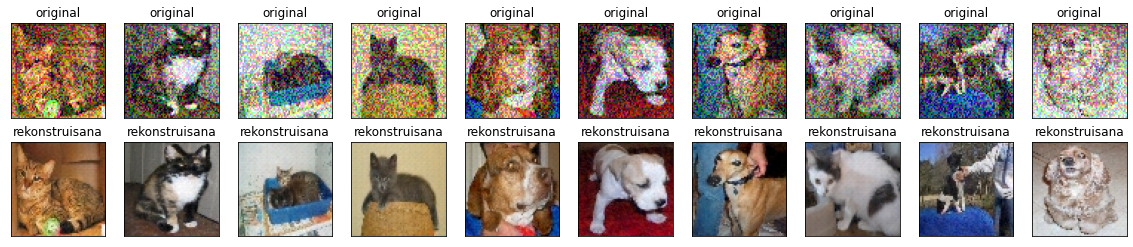

In [ ]:
fgsmDenoiser.train_autoencoder()

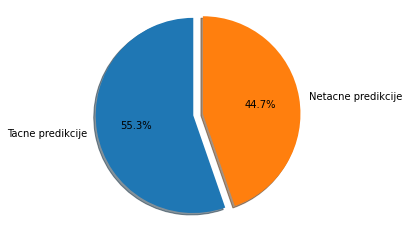

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(x_test_attacked=val[2])

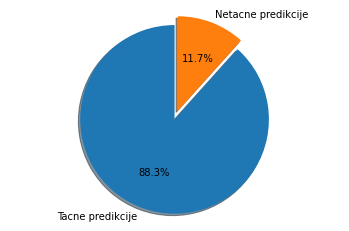

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=fgsmDenoiser,x_test_attacked=val[2])

#GAUSSIAN BLUR NAPAD

In [ ]:
val = create_attack(x_train,x_test,3,(64,64,3))

In [ ]:
gaussDenoiser = val[0]

Epoch 1/15
582/582 [==============================] - 20s 33ms/step - loss: 0.0261
Epoch 2/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0040
Epoch 3/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0029
Epoch 4/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0024
Epoch 5/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0022
Epoch 6/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0020
Epoch 7/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0019
Epoch 8/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0018
Epoch 9/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0018
Epoch 10/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0017
Epoch 11/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0017
Epoch 12/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0015
E

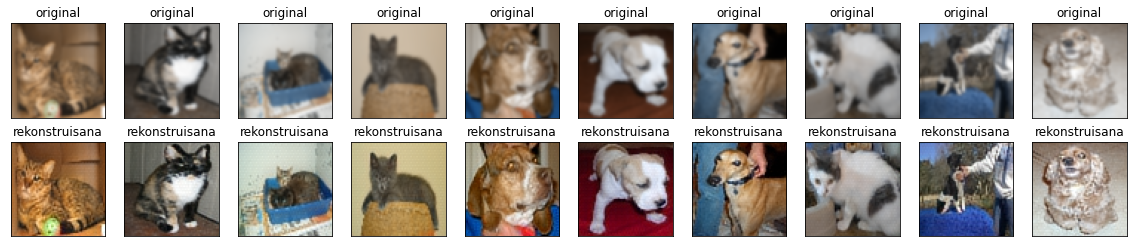

In [ ]:
gaussDenoiser.train_autoencoder()

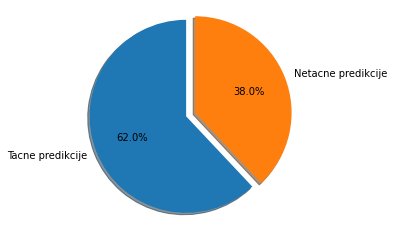

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(val[2])

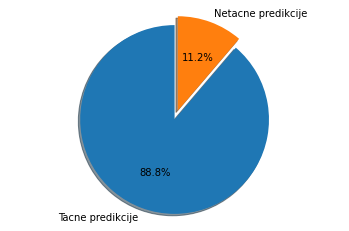

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=gaussDenoiser,x_test_attacked= val[2])

#MISSING PIXEL NAPAD

In [ ]:
val = create_attack(x_train,x_test,4,(64,64,3))

In [ ]:
misPDenoiser = val[0]

Epoch 1/15
582/582 [==============================] - 20s 33ms/step - loss: 0.0261
Epoch 2/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0025
Epoch 3/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0014
Epoch 4/15
582/582 [==============================] - 19s 33ms/step - loss: 0.0011
Epoch 5/15
582/582 [==============================] - 19s 33ms/step - loss: 9.2292e-04
Epoch 6/15
582/582 [==============================] - 19s 33ms/step - loss: 8.6218e-04
Epoch 7/15
582/582 [==============================] - 19s 33ms/step - loss: 7.9301e-04
Epoch 8/15
582/582 [==============================] - 19s 33ms/step - loss: 9.4469e-04
Epoch 9/15
582/582 [==============================] - 19s 33ms/step - loss: 6.7572e-04
Epoch 10/15
582/582 [==============================] - 19s 33ms/step - loss: 6.9109e-04
Epoch 11/15
582/582 [==============================] - 19s 33ms/step - loss: 6.6876e-04
Epoch 12/15
582/582 [==============================] - 19

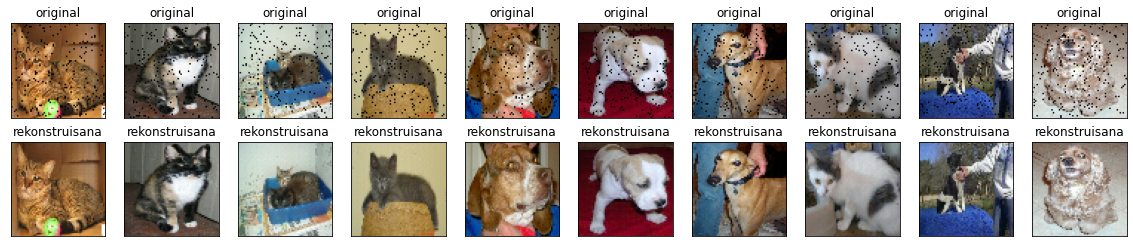

In [ ]:
misPDenoiser.train_autoencoder()

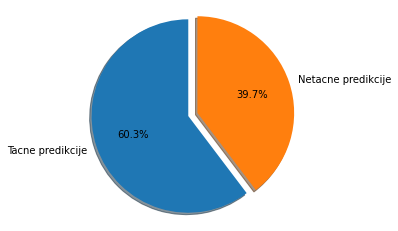

In [ ]:
clas.procenat_tacnosti_pre_ciscenja(val[2])

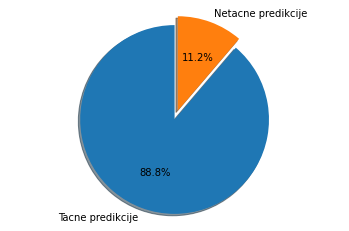

In [ ]:
clas.procenat_tacnosti_posle_ciscenja(denoiser=misPDenoiser,x_test_attacked= val[2])